<a href="https://colab.research.google.com/github/rai-stein/Learning-Voting-Trees/blob/main/SocialChoice_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Choice - Implementation part
Raissa Chut Steinberg & Aviv Kapitulnik

Following our discussion on the paper "Learning Voting Trees", which discussed thoroughly the complexity of learning concise voting trees given tournaments and their winners.

What we wish to acomplish in this part is, opposed to the empirical work shown on the paper and learning an almost-perfect voting tree, we will be using a greedy algorithm (explained below) that will assist us in creating a good approximation to a concise voting tree of relevant chosen voting rules

Importing the relevant libraries:


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import matplotlib.cm as cm
import itertools
import copy
import time
from itertools import permutations
from itertools import combinations
from tqdm import tqdm

The following functions will be useful to us when defining tournaments and using known voting rules:

In [ ]:
def edges_in_cycles(graph):
    """
    : param: graph - the graph we want to check (the tournament)
    : return: edges in cycles in the graph
    """
    cycles = list(nx.simple_cycles(graph))
    edges_in_cycles = set()
    for cycle in cycles:
        for i in range(len(cycle)):
            u,v = cycle[i],cycle[(i+1)%len(cycle)]
            edges_in_cycles.add((u,v))
    return edges_in_cycles

def break_cycle_brute(graph):
    """
    : param: graph - the graph we want to make acyclical
    : return: the minimal weight we have to "change" to make the graph acyclical
    """
    rel_edges = edges_in_cycles(graph)

    if len(rel_edges) == 0 : ## no cycles
        return 0

    rel_weighted = [(u,v,graph[u][v]['weight']) for u,v in rel_edges]

    min_weight = float('inf')

    for r in range(1,len(rel_weighted)+1):
        for subset in combinations(rel_weighted, r):
            graph_2play2 = graph.copy()
            weight_sum = 0

            for u,v,weight in subset:
                graph_2play2.remove_edge(u, v)
                weight_sum += weight

            try:
                nx.find_cycle(graph_2play2)
            except:
                if weight_sum < min_weight:
                    min_weight = weight_sum
    return min_weight

def make_graph(entries, candidates, print_it):
    """
    :param entries: the rankings given by voters
    :param candidates: the alternatives
    :param print_it: whether we want to prin the tournament graph or not
    :return: the graph that defines the tournament
    Edges from winner to loser
    ## Used to help define the tournament ##
    """

    prefs = entries
    names = list(candidates)

    graph = nx.DiGraph()
    graph.add_nodes_from(names)

    for a in graph.nodes:
        for b in graph.nodes:
            if names.index(a) < names.index(b):
                w, l, wei = winner_one_on_one(entries, a, b)
                graph.add_weighted_edges_from([(w, l, wei)])

    # print it if required :)
    if print_it:
      pos = nx.spring_layout(graph, k=100)
      nx.draw(graph, pos, with_labels=True, node_color='lightpink', edge_color='gray', node_size=800, font_size=15)
      edge_labels = nx.get_edge_attributes(graph, 'weight')
      nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
      plt.show()

    return graph

def winner_one_on_one(entries, a, b):
    """
    :param entries: the rankings
    :param a: alt a
    :param b: alt b
    :return: who wins in pairwise comparison between a and b!
    ## Used to help define the tournament ##
    """
    prefs = entries

    vote_a = 0
    vote_b = 0

    for i in range(len(prefs)):
        if list(prefs[i]).index(a) < list(prefs[i]).index(b):
            vote_a += 1
        else: vote_b += 1

    weight = max(vote_a, vote_b)

    if vote_a > vote_b:
        winner = a
        loser = b
    elif vote_a < vote_b:
        winner = b
        loser = a
    else:
        winner = min(a, b)
        loser = max(a, b)

    return winner, loser, weight

The voting rules we wish to use:

In [ ]:
def borda_rule(entries, candidates):
    """
    :param entries: the rankings
    :param candidates: the alternatives
    :return: the ranking according to the borda rule and its winner
    """
    prefs = entries
    names = list(candidates)

    hist = [0 for i in range(len(candidates))]

    for i in range(len(prefs)):
        for j in range(len(names)):
            place = names.index(prefs[i][j])
            hist[place] += (len(names) - 1 - j)

    hist_with_names = []

    for i in range(len(hist)):
        hist_with_names.append((names[i], hist[i]))

    ranking_tuples = sorted(hist_with_names, key=lambda x: (-x[1], x[0]), reverse=False)

    ranking = []
    for i in range(len(ranking_tuples)):
        ranking.append(ranking_tuples[i][0])

    winner = ranking[0]

    return ranking, winner

def plurality_rule(entries, candidates):
    """
    :param entries: the rankings
    :param candidates: the alternatives
    :return: the ranking according to the plurality rule and its winner
    """
    prefs = entries
    names = list(candidates)

    hist = [0 for i in range(len(candidates))]

    for i in range(len(prefs)):
        winner_i = names.index(prefs[i][0])
        hist[winner_i] += 1

    hist_with_names = []

    for i in range(len(hist)):
        hist_with_names.append((names[i], hist[i]))

    ranking_tuples = sorted(hist_with_names, key=lambda x: (-x[1], x[0]), reverse=False)

    ranking = []
    for i in range(len(ranking_tuples)):
        ranking.append(ranking_tuples[i][0])

    winner = ranking[0]

    return ranking, winner

def copland_rule(entries, candidates):
    """
    :param profile: profile of voters
    :param candidates: the candidates of the tournament
    :return list: a ranking of all candidates by Copland with lexicographic tie-breaking, from winner to loser
    and its winner
    """

    names = list(candidates)

    graph = make_graph(entries, candidates, print_it=False)

    out_degrees = list(graph.out_degree())

    ranking_tuples = sorted(out_degrees, key=lambda x: (-x[1], x[0]), reverse=False)

    ranking = []
    for i in range(len(ranking_tuples)):
        ranking.append(ranking_tuples[i][0])

    winner = ranking[0]

    return ranking, winner

def irv_rule(entries, candidates): # Instant-Runoff Voting (IRV) rule
    """
    :param entries: the rankings given by voters (list of lists)
    :param candidates: the set of alternatives
    :return: the ranking according to IRV and its winner
    """

    active_candidates = list(candidates)
    prefs = copy.deepcopy(entries)

    while len(active_candidates) > 1:
        first_choice_counts = {cand: 0 for cand in active_candidates}

        for pref in prefs:
            for cand in pref:
                if cand in active_candidates:
                    first_choice_counts[cand] += 1
                    break

        total_votes = sum(first_choice_counts.values())
        for cand, count in first_choice_counts.items():
            if count > total_votes / 2:
                return [cand], cand

        min_votes = min(first_choice_counts.values())
        to_eliminate = [cand for cand, count in first_choice_counts.items() if count == min_votes]

        if len(to_eliminate) == len(active_candidates):
            break

        for cand in to_eliminate:
            active_candidates.remove(cand)

        for pref in prefs:
            for cand in to_eliminate:
                if cand in pref:
                    pref = np.delete(pref, np.where(pref == cand))

    # The last remaining candidate is the winner
    winner = list(active_candidates)[0]
    return [winner], winner

The data set we'll be using is called Jester Data, the data was collected between April 1999 and May 2003 and contains 24,983 continuous ratings from -10 to +10 of 100 different jokes. The source stated that the jokes (alternatives) $\in$ [5, 7, 8, 13, 15, 16, 17, 18, 19, 20] were ranked by almost all users, so we took all ratings that ranked all of them and used them as our base dataset (Not taking into consideration the rest of the jokes).

An example to one of the jokes presented to the voters (joke 1):

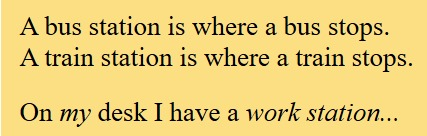

Link to source:
[Jester data set](https://goldberg.berkeley.edu/jester-data/)

Firstly, we'll read the data from the file and make it into rankings we know how to work with. The functions for said actions:

In [ ]:
def extract_data(path):
    """
    :param path:
    :return: dataFrame of the rankings - each line is a ranking of a certain voter
    """
    df = pd.read_excel(path, header=None)
    df.columns = ["amount"] + [i for i in range(100)]
    return df

def remove_less_than_k(rankings,k):
    """
    :param rankings: matrix of ranking of each participant of the jokes
    :param k: number of jokes (alternatives) ranked
    :return: the rankings that ranked enough jokes (at least k), hence the ones that are relevant to us
    """
    rankings_to_return = rankings[rankings.iloc[:,0] >= k].drop("amount", axis=1)
    return rankings_to_return

def votes_to_rankings(rankings):
    """
    :param rankings: the ranking in grades (as given)
    :return: translating the grades (given ranking) into a total ordered ranking
    The one relevant from our perspective
    """
    sorted_indices_df = pd.DataFrame(np.argsort(-rankings.values, axis=1), index = rankings.index)
    return sorted_indices_df

def relevant_rankings(rankings, relevant_alts):
    """
    :param rankings: the ranking in grades (as given)
    :return: the rankings, over the relevant alternatives given by the source
    """
    relevant_rankings = rankings.iloc[:,relevant_alts]
    num_diff_99 = []
    for idx, row in relevant_rankings.iterrows():
        num_diff_99.append(sum(row != 99))
    relevant_rankings.loc[:,"amount"] = num_diff_99
    return relevant_rankings

After having all relevant rankings, given the nature of what we're working with and checking we'll want to separate the data into two groups, train and test. This will make it possible for the learning to be "legal".

Additionaly, each set (train/test) is divided into batches, each batch will be used to define a tournament (pairwise comparisons inside the batch, what would be defined in the tournament graph as we know it). Which will be useful to us in the main part of the implementation.

In [ ]:
def create_train_batches_test(rankings, train_percentage, batch_size):
    """
    : param: rankings
    : param: train_percentage
    : param: batch_size - the size of each batch (each tournament will be defined by one batch)
    : return: train, batches_train, test, batches_test
    """
    train_size = int(len(rankings)*train_percentage)
    train = rankings.sample(n = train_size)
    test = rankings.drop(train.index)
    num_batches_train = len(rankings) // batch_size
    batches_train = np.array_split(train.to_numpy(), num_batches_train)
    num_batches_test = len(test) // batch_size
    batches_test = np.array_split(test.to_numpy(), num_batches_test)

    return train, batches_train, test, batches_test

def create_tournaments(ranking,alternatives):
    """
    :param rankings: the full rankings already translated to indexes (and not grades)
    :return: for each voting rule, a data set like described on the project
    """
    tour = make_graph(ranking, alternatives, print_it=False)
    return tour

Our implementation relies on building voting trees and learning a certain (given) voting rule trying to make the tree as concise as possible with regards to it. That is, the leaves assignment is as good as it can be with a certain margin of error $\epsilon$.

To be able to talk about the dependancy of how good we can learn a voting rule on the number of leaves of the voting tree we want to learn, the class defined below gives us the tools to generate trees while controling now necessairly the depth of said tree, but the number of leaves we'll dead with.

In [ ]:
class Node:
    def __init__(self,id):
        self.id = id # who the node is
        self.value = -1 # who the node represents (alternative)
        self.left = None
        self.right = None

    def change_value(self,value): # changing who the node represents
        self.value = value

    def deepcopy(self):
        new_node = Node(self.id)
        new_node.value = self.value
        new_node.left = self.left
        new_node.right = self.right
        return new_node

In [ ]:
class votingTree:
    def __init__(self,root):
        self.root = Node(root)

    def insert_left(self,current_node,id):
        if current_node.left is None:
            current_node.left = Node(id)
        else:
            new_node = Node(id)
            new_node.left = current_node.left
            current_node.left = new_node

    def insert_right(self,current_node,id):
        if current_node.right is None:
            current_node.right = Node(id)
        else:
            new_node = Node(id)
            new_node.right = current_node.right
            current_node.right = new_node

    def generate_balanced_tree(self,num_leaves):
        """
        : returns: the root and a list with the leaves objects (nodes)
        Where the root is root to a balanced tree with 'num_leaves' leaves
        -> Balanced tree or almost balanced tree - all leaves are either on the last level of the tree
        or on the one before that
        """
        leaves = [self.root]
        nodes_to_process = [self.root]
        # we keep in "nodes_to_process" all nodes that can still have more successors
        # nodes who still do not have 2 children (we talk about binary voting trees!)

        leaves_left = num_leaves
        bruh = 1
        while leaves_left > 0: # while we still need to add leaves
            current_node = nodes_to_process[0]
            if current_node.left is None:
              self.insert_left(current_node, f"node {bruh + 1}")
              bruh += 1
              if current_node in leaves:
                leaves.remove(current_node)
              leaves.append(current_node.left)
              if current_node == self.root:
                leaves_left -= 1
              nodes_to_process.append(current_node.left)

            else: # current_node.right is None:
              self.insert_right(current_node, f"node {bruh + 1}")
              bruh += 1
              # if current_node in leaves: # this will never happen because we add left before right always
              #   leaves.remove(current_node)
              leaves.append(current_node.right)
              leaves_left -= 1
              nodes_to_process.append(current_node.right)
              nodes_to_process.remove(current_node)

        return self.root, leaves

    def generate_random_tree(self, num_leaves):
        """
        : returns: the root and a list with the leaves objects (nodes)
        Where the root is root to a random tree with 'num_leaves' leaves
        """
        leaves = [self.root]
        nodes_to_process = [self.root]
        # we keep in "nodes_to_process" all nodes that can still have more successors
        # nodes who still do not have 2 children (we talk about binary voting trees!)
        bruh = 1
        while len(leaves) < num_leaves: #while we haven't gotten to the number of leaves wanted
            current_node = random.choice(nodes_to_process)
            is_leaf = True

            # Randomly decide to insert a left or right child
            if random.choice([True, False]):
                if current_node.left is None:
                    self.insert_left(current_node, f"node {bruh+1}")
                    if current_node in leaves:
                        leaves.remove(current_node)
                    leaves.append(current_node.left)
                    nodes_to_process.append(current_node.left)
                    bruh+=1

            else:
                if current_node.right is None:
                    self.insert_right(current_node, f"node {bruh+1}")
                    if current_node in leaves:
                        leaves.remove(current_node)
                    leaves.append(current_node.right)
                    nodes_to_process.append(current_node.right)
                    bruh += 1

            if current_node.left and current_node.right:
                  nodes_to_process.remove(current_node)

        return self.root, leaves

    def draw_tree(self): # drawing the tree with the leaves being a different color :)
        G = nx.DiGraph()
        self._add_edges(self.root, G)
        pos = self._get_node_positions(self.root)
        labels = {node.id: node.id for node in self._get_nodes(self.root)}

        # Identify leaf nodes
        leaves = [node for node in self._get_nodes(self.root) if node.left is None and node.right is None]

        # Assign colors: lightblue for internal nodes, lightgreen for leaves
        node_colors = []
        for node in self._get_nodes(self.root):
            if node in leaves:
                node_colors.append("lightpink")  # Color for leaves
            else:
                node_colors.append("lightgreen")  # Color for internal nodes

        # Draw the graph
        nx.draw(
            G,
            pos,
            with_labels=True,
            labels=labels,
            node_size=1000,
            node_color=node_colors,  # Use the list of colors
            font_size=12,
            arrows=False,
        )
        plt.show()

    def _add_edges(self, node, graph):
        if node.left:
            graph.add_edge(node.id, node.left.id)
            self._add_edges(node.left, graph)
        if node.right:
            graph.add_edge(node.id, node.right.id)
            self._add_edges(node.right, graph)

    def _get_node_positions(self, node, pos=None, x=0, y=0, layer=1):
        if pos is None:
            pos = {node.id: (x, y)}
        else:
            pos[node.id] = (x, y)

        if node.left:
            pos = self._get_node_positions(node.left, pos, x - 1 / layer, y - 1, layer + 1)
        if node.right:
            pos = self._get_node_positions(node.right, pos, x + 1 / layer, y - 1, layer + 1)

        return pos

    def _get_nodes(self, node):
        nodes = [node]
        if node.left:
            nodes.extend(self._get_nodes(node.left))
        if node.right:
            nodes.extend(self._get_nodes(node.right))
        return nodes

Now we have the trees defined as desired and also a given tournament. The following functions will assist us in finding the winner of a tournament with the help of the voting tree.

That is, will perform the backwards induction we discussed in our project and provided the Helpful Figure on.

In [ ]:
def find_winner(alt1,alt2,tournament,alternatives):
    """
    : param: alt1
    : param: alt2
    : param: tournament
    : param: alternatives
    : return: the winner between alt1 and alt2 according to the tournament
    -> Performs the basic step of the backwards induction discussed in our project/the paper
    """
    if alt1 == -1:
        return alt2
    if alt2 == -1:
        return alt1

    if tournament.has_edge(alt1,alt2):
        return alt1

    elif tournament.has_edge(alt2,alt1):
        return alt2

def simulate_tree(root, tournament, alternatives):
    """
    : param: root
    : param: tournament
    : param: alternatives
    : return: the winner of the tournament according to the tree
    -> Performs the backwards induction discussed in our project/the paper
    """
    nodes_lst = [] # the nodes which still haven't been "decided"
    if root.left:
        nodes_lst.append(root.left)
    if root.right:
        nodes_lst.append(root.right)
    if len(nodes_lst) == 0:
        return root.value
    elif len(nodes_lst) == 1:
        return simulate_tree(nodes_lst[0], tournament,alternatives)
    else: # if we're here then "root" is parent of two leaves!
        winner1 = simulate_tree(nodes_lst[0],tournament,alternatives)
        winner2 = simulate_tree(nodes_lst[1],tournament,alternatives)
        return find_winner(winner1,winner2,tournament,alternatives)

After all of the definitions above we're finally ready to start actually learning the trees of each voting rule according to our world.

Check how accurate a certain leaves assignment 'leaves' on a tree based on root 'root' is over a given set of tournaments and their winners (our sample space)

In [ ]:
def check_accuracy(root, leaves, alternatives, tour_win):
  """
  : param: root
  : param: leaves
  : param: alternatives
  : param: tour_win: the sample space - a dictionary of the batches (sub-samples), each value is a tuple of (tournament, (winning_ranking, winner))
  : return: the number of times the leaves assignment leads us to the correct winner on the sample space tour_win
  """
  correct = 0
  for i, batch in enumerate(tour_win):
    winner = simulate_tree(root, tour_win[i][0], alternatives)
    correct += (winner == tour_win[i][1][1])
  return correct

In [ ]:
def list_node_deepcopy(node_list):
  new_list = []
  for nod in node_list:
    new_list.append(nod.deepcopy())
  return new_list

In [ ]:
def learn_tree(root, leaves, alternatives, tour_win : dict):
  """
  : param: root
  : param: leaves
  : param: alternatives
  : param: tour_win: the sample space - a dictionary of the batches (sub-samples), each value is a tuple of (tournament, (winning_ranking, winner))
  : return: the leaves assignment that leads us to the correct winner on the sample space tour_win
  """
  for leaf in leaves:
    leaf.value = -1

  correct = check_accuracy(root, leaves, alternatives, tour_win)

  # here we are going to use a greedy algo to learn the placement

  for i in tqdm(range(20)):
    # the former assignment
    leaves_former = list_node_deepcopy(leaves)
    for leaf in leaves:
      placement_value = []
      for alt in alternatives:
        leaf.value = alt
        placement_value.append(check_accuracy(root, leaves, alternatives, tour_win) - correct)
      correct += max(placement_value)
      leaf.value = alternatives[placement_value.index(max(placement_value))]
    if leaves_former == leaves or correct == len(tour_win):
      break
  # print("my n word")
  return leaves

  # todo: the accuracy doesnt run on the real tree

Main running:

In [ ]:
voting_rules = ['borda', 'plurality', 'copland', 'irv']
# alternatives = [i for i in range(1,101)]
# according to the source, the alternative which recieved the most ratings
more_relevant_alternatives = [0, 5, 7, 8, 13, 15, 16, 17, 18, 19, 20]
alts_idx = [i for i in range(len(more_relevant_alternatives)-1)]
# more_rel_alts = [4, 6, 7, 12, 14, 15, 16, 17, 18, 19] # in index

In [ ]:
# with most relevant 10 candidates!
path = "jester-data-1.xls"
votes = extract_data(path)
relevant_votes = relevant_rankings(votes, more_relevant_alternatives)
full_votes = remove_less_than_k(relevant_votes,k = len(more_relevant_alternatives) - 1)
rankings = votes_to_rankings(full_votes)
train, batches_train, test, batches_test = create_train_batches_test(rankings,0.8,100)

In [ ]:
dict_tour_win = {}
for vr in voting_rules:
  dict_tour_win[vr] = {}
  for i, batch in enumerate(batches_train):
    if vr == 'borda':
      dict_tour_win[vr][i] = (create_tournaments(batch,alts_idx), borda_rule(batch, alts_idx))
    elif vr == 'plurality':
      dict_tour_win[vr][i] = (create_tournaments(batch,alts_idx), plurality_rule(batch, alts_idx))
    elif vr == 'copland':
      dict_tour_win[vr][i] = (create_tournaments(batch,alts_idx), copland_rule(batch, alts_idx))
    else:
      dict_tour_win[vr][i] = (create_tournaments(batch,alts_idx), irv_rule(batch, alts_idx))

In [ ]:
# create different tree structures we'll use for our voting trees!
trees = {}
# all different types of tree structures we will use
types = ['balanced', '1st rand', '2nd rand', '3rd rand', '4th rand', '5th rand']
# the different leaves number we're interested in checking
leafs_num = [2, 4, 8, 12, 16, 24, 32, 40, 48, 56, 64]

for leaf in leafs_num:
  trees[leaf] = {}
  for typ in types:
    trees[leaf][typ] = {}

for leaf in leafs_num:
  for typ in types:
    if typ != 'balanced':
      rand_tree = votingTree("root")  # Start with root value 1
      rand_root,rand_leaves = rand_tree.generate_random_tree(leaf) # generate a random tree structure with 4 leaves
      trees[leaf][typ] = (rand_tree, rand_root, rand_leaves)
    else:
      bal_tree = votingTree("root")  # Start with root value 1
      bal_root,bal_leaves = bal_tree.generate_balanced_tree(leaf) # generate a random tree structure with 4 leaves
      trees[leaf][typ] = (bal_tree, bal_root, bal_leaves)

Now that the environment we want to learn is created (the trees we will learn for each voting rule, for each number of leaves), we can perform a greedy learning algorithm that will leave us with a concise representation of each voting rule.

In other words, the trees will (hopefully) almost always be able to tell us the (rightfull) winner of a tournament when the latter is given.

After the previous step, we have all the trees needed already learned!

Now we will calculate the accuracy of each voting tree learned for each voting rule, number of leaves and different structures created. (The accuracies over each of the different structures will be shown in three manners : the balanced tree, average of the random trees and average of all structures put together)

In [ ]:
# calculate the accuracies on the test set
dict_tour_win_test = {}
for vr in voting_rules:
  dict_tour_win_test[vr] = {}
  for i, batch in enumerate(batches_test):
    if vr == 'borda':
      dict_tour_win_test[vr][i] = (create_tournaments(batch,alts_idx), borda_rule(batch, alts_idx))
    elif vr == 'plurality':
      dict_tour_win_test[vr][i] = (create_tournaments(batch,alts_idx), plurality_rule(batch, alts_idx))
    elif vr == 'copland':
      dict_tour_win_test[vr][i] = (create_tournaments(batch,alts_idx), copland_rule(batch, alts_idx))
    else:
      dict_tour_win_test[vr][i] = (create_tournaments(batch,alts_idx), irv_rule(batch, alts_idx))

In [ ]:
time_learn_dict = {}
accuracies_train = {}
accuracies_test = {}

start_time = time.time()

for vr in voting_rules:
  time_learn_dict[vr] = {}
  accuracies_train[vr] = {}
  accuracies_test[vr] = {}

  for leaf in leafs_num:
    time_learn_dict[vr][leaf] = {}
    accuracies_train[vr][leaf] = {}
    accuracies_test[vr][leaf] = {}

    for typ in types:
      iteration_start = time.time()

      tree = trees[leaf][typ][0]
      root = trees[leaf][typ][1]
      leaves = trees[leaf][typ][2]

      leaves_assignment = learn_tree(root, leaves, alts_idx, dict_tour_win[vr])

      for leaf1, leaf2 in zip(leaves, leaves_assignment): # what actually changes the values of the leaves
      # (who they represent!)
        if leaf1.id == leaf2.id:
          leaf1.value = leaf2.value

      iteration_end = time.time()
      iteration_time = iteration_end - iteration_start

      time_learn_dict[vr][leaf][typ] = iteration_time
      accuracies_train[vr][leaf][typ] = check_accuracy(root, leaves, alts_idx, dict_tour_win[vr]) / len(dict_tour_win[vr])
      accuracies_test[vr][leaf][typ] = check_accuracy(root, leaves, alts_idx, dict_tour_win_test[vr]) / len(dict_tour_win_test[vr])

      print(f'Iteration Time: {iteration_time:.2f} sec')

end_time = time.time()  # End timing the whole process
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} sec")

100%|██████████| 20/20 [00:00<00:00, 190.59it/s]


Iteration Time: 0.12 sec


100%|██████████| 20/20 [00:00<00:00, 166.09it/s]


Iteration Time: 0.12 sec


100%|██████████| 20/20 [00:00<00:00, 80.56it/s] 


Iteration Time: 0.25 sec


100%|██████████| 20/20 [00:00<00:00, 105.66it/s]


Iteration Time: 0.20 sec


100%|██████████| 20/20 [00:00<00:00, 92.31it/s]


Iteration Time: 0.22 sec


100%|██████████| 20/20 [00:00<00:00, 79.68it/s]


Iteration Time: 0.26 sec


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Iteration Time: 0.90 sec


100%|██████████| 20/20 [00:01<00:00, 17.34it/s]


Iteration Time: 1.16 sec


100%|██████████| 20/20 [00:00<00:00, 33.28it/s]


Iteration Time: 0.61 sec


100%|██████████| 20/20 [00:00<00:00, 29.84it/s]


Iteration Time: 0.68 sec


100%|██████████| 20/20 [00:00<00:00, 27.48it/s]


Iteration Time: 0.73 sec


100%|██████████| 20/20 [00:01<00:00, 18.69it/s]


Iteration Time: 1.08 sec


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Iteration Time: 2.64 sec


100%|██████████| 20/20 [00:02<00:00,  7.00it/s]


Iteration Time: 2.86 sec


100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Iteration Time: 3.79 sec


100%|██████████| 20/20 [00:03<00:00,  6.25it/s]


Iteration Time: 3.21 sec


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


Iteration Time: 2.97 sec


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


Iteration Time: 2.79 sec


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Iteration Time: 5.97 sec


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Iteration Time: 6.52 sec


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


Iteration Time: 8.01 sec


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Iteration Time: 6.96 sec


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Iteration Time: 6.65 sec


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Iteration Time: 7.83 sec


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Iteration Time: 8.76 sec


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Iteration Time: 12.16 sec


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Iteration Time: 11.69 sec


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Iteration Time: 12.36 sec


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Iteration Time: 12.98 sec


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Iteration Time: 12.17 sec


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Iteration Time: 22.79 sec


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Iteration Time: 30.89 sec


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Iteration Time: 30.09 sec


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Iteration Time: 28.42 sec


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Iteration Time: 23.43 sec


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Iteration Time: 27.72 sec


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Iteration Time: 39.47 sec


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


Iteration Time: 51.06 sec


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


Iteration Time: 51.03 sec


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Iteration Time: 51.98 sec


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Iteration Time: 48.76 sec


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Iteration Time: 47.43 sec


100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


Iteration Time: 61.44 sec


100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Iteration Time: 74.13 sec


100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


Iteration Time: 81.69 sec


100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


Iteration Time: 78.35 sec


100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


Iteration Time: 85.23 sec


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Iteration Time: 72.94 sec


100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Iteration Time: 86.95 sec


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Iteration Time: 118.28 sec


100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


Iteration Time: 119.67 sec


100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


Iteration Time: 112.79 sec


100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


Iteration Time: 121.81 sec


100%|██████████| 20/20 [02:00<00:00,  6.00s/it]


Iteration Time: 120.03 sec


100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


Iteration Time: 119.22 sec


100%|██████████| 20/20 [02:42<00:00,  8.14s/it]


Iteration Time: 162.77 sec


100%|██████████| 20/20 [02:42<00:00,  8.14s/it]


Iteration Time: 162.90 sec


100%|██████████| 20/20 [02:43<00:00,  8.20s/it]


Iteration Time: 163.93 sec


100%|██████████| 20/20 [02:34<00:00,  7.70s/it]


Iteration Time: 154.06 sec


100%|██████████| 20/20 [02:39<00:00,  7.95s/it]


Iteration Time: 159.05 sec


100%|██████████| 20/20 [02:33<00:00,  7.69s/it]


Iteration Time: 153.75 sec


100%|██████████| 20/20 [03:24<00:00, 10.25s/it]


Iteration Time: 204.99 sec


100%|██████████| 20/20 [03:14<00:00,  9.71s/it]


Iteration Time: 194.25 sec


100%|██████████| 20/20 [03:31<00:00, 10.55s/it]


Iteration Time: 211.03 sec


100%|██████████| 20/20 [03:28<00:00, 10.41s/it]


Iteration Time: 208.23 sec


100%|██████████| 20/20 [03:24<00:00, 10.21s/it]


Iteration Time: 204.24 sec


100%|██████████| 20/20 [00:00<00:00, 195.32it/s]


Iteration Time: 0.11 sec


100%|██████████| 20/20 [00:00<00:00, 164.63it/s]


Iteration Time: 0.13 sec


100%|██████████| 20/20 [00:00<00:00, 123.55it/s]


Iteration Time: 0.17 sec


100%|██████████| 20/20 [00:00<00:00, 192.91it/s]


Iteration Time: 0.11 sec


100%|██████████| 20/20 [00:00<00:00, 145.03it/s]


Iteration Time: 0.14 sec


100%|██████████| 20/20 [00:00<00:00, 156.24it/s]


Iteration Time: 0.13 sec


100%|██████████| 20/20 [00:00<00:00, 39.30it/s]


Iteration Time: 0.51 sec


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Iteration Time: 0.78 sec


100%|██████████| 20/20 [00:00<00:00, 32.49it/s]


Iteration Time: 0.62 sec


100%|██████████| 20/20 [00:00<00:00, 30.30it/s]


Iteration Time: 0.66 sec


100%|██████████| 20/20 [00:00<00:00, 33.55it/s]


Iteration Time: 0.60 sec


100%|██████████| 20/20 [00:00<00:00, 35.47it/s]


Iteration Time: 0.57 sec


100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Iteration Time: 2.16 sec


100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Iteration Time: 3.79 sec


100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Iteration Time: 2.90 sec


100%|██████████| 20/20 [00:03<00:00,  6.21it/s]


Iteration Time: 3.23 sec


100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


Iteration Time: 2.96 sec


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Iteration Time: 3.98 sec


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Iteration Time: 5.01 sec


100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


Iteration Time: 6.99 sec


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Iteration Time: 6.45 sec


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Iteration Time: 7.55 sec


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Iteration Time: 6.00 sec


100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


Iteration Time: 7.77 sec


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


Iteration Time: 9.39 sec


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Iteration Time: 12.13 sec


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Iteration Time: 11.06 sec


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Iteration Time: 12.18 sec


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Iteration Time: 14.65 sec


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Iteration Time: 12.11 sec


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Iteration Time: 21.71 sec


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Iteration Time: 29.83 sec


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Iteration Time: 29.43 sec


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Iteration Time: 28.33 sec


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Iteration Time: 23.18 sec


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Iteration Time: 29.03 sec


100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


Iteration Time: 38.18 sec


100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Iteration Time: 49.62 sec


100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


Iteration Time: 53.04 sec


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Iteration Time: 51.12 sec


100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Iteration Time: 48.27 sec


100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


Iteration Time: 46.62 sec


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


Iteration Time: 60.59 sec


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Iteration Time: 72.98 sec


100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


Iteration Time: 80.70 sec


100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


Iteration Time: 76.45 sec


100%|██████████| 20/20 [01:22<00:00,  4.12s/it]


Iteration Time: 82.50 sec


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Iteration Time: 72.66 sec


100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


Iteration Time: 85.55 sec


100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


Iteration Time: 113.82 sec


100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Iteration Time: 115.45 sec


100%|██████████| 20/20 [01:51<00:00,  5.55s/it]


Iteration Time: 111.03 sec


100%|██████████| 20/20 [01:56<00:00,  5.83s/it]


Iteration Time: 116.57 sec


100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


Iteration Time: 119.91 sec


100%|██████████| 20/20 [01:54<00:00,  5.73s/it]


Iteration Time: 114.66 sec


100%|██████████| 20/20 [02:37<00:00,  7.85s/it]


Iteration Time: 157.04 sec


100%|██████████| 20/20 [02:37<00:00,  7.86s/it]


Iteration Time: 157.27 sec


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


Iteration Time: 160.11 sec


100%|██████████| 20/20 [02:30<00:00,  7.55s/it]


Iteration Time: 151.01 sec


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


Iteration Time: 156.94 sec


100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


Iteration Time: 150.83 sec


100%|██████████| 20/20 [03:19<00:00,  9.97s/it]


Iteration Time: 199.32 sec


100%|██████████| 20/20 [03:12<00:00,  9.61s/it]


Iteration Time: 192.20 sec


100%|██████████| 20/20 [03:24<00:00, 10.24s/it]


Iteration Time: 204.83 sec


100%|██████████| 20/20 [03:22<00:00, 10.10s/it]


Iteration Time: 202.04 sec


100%|██████████| 20/20 [03:19<00:00,  9.96s/it]


Iteration Time: 199.28 sec


100%|██████████| 20/20 [00:00<00:00, 103.95it/s]

Iteration Time: 0.20 sec

100%|██████████| 20/20 [00:00<00:00, 80.98it/s]


Iteration Time: 0.25 sec


100%|██████████| 20/20 [00:00<00:00, 66.81it/s]


Iteration Time: 0.31 sec


100%|██████████| 20/20 [00:00<00:00, 109.53it/s]


Iteration Time: 0.19 sec


100%|██████████| 20/20 [00:00<00:00, 85.89it/s]


Iteration Time: 0.24 sec


100%|██████████| 20/20 [00:00<00:00, 83.66it/s]


Iteration Time: 0.24 sec


100%|██████████| 20/20 [00:00<00:00, 30.10it/s]


Iteration Time: 0.67 sec


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Iteration Time: 0.78 sec


100%|██████████| 20/20 [00:00<00:00, 32.44it/s]


Iteration Time: 0.62 sec


100%|██████████| 20/20 [00:00<00:00, 30.23it/s]


Iteration Time: 0.67 sec


100%|██████████| 20/20 [00:00<00:00, 33.18it/s]


Iteration Time: 0.61 sec


100%|██████████| 20/20 [00:00<00:00, 34.95it/s]


Iteration Time: 0.58 sec


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Iteration Time: 2.09 sec


100%|██████████| 20/20 [00:02<00:00,  7.00it/s]


Iteration Time: 2.86 sec


100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


Iteration Time: 3.55 sec


100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


Iteration Time: 3.38 sec


100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


Iteration Time: 3.03 sec


100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


Iteration Time: 2.81 sec


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Iteration Time: 5.85 sec


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Iteration Time: 5.92 sec


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Iteration Time: 7.14 sec


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Iteration Time: 6.27 sec


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Iteration Time: 7.22 sec


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Iteration Time: 7.62 sec


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


Iteration Time: 8.46 sec


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Iteration Time: 11.96 sec


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Iteration Time: 12.92 sec


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Iteration Time: 12.29 sec


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Iteration Time: 12.77 sec


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Iteration Time: 12.14 sec


100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Iteration Time: 21.94 sec


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Iteration Time: 29.60 sec


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Iteration Time: 30.27 sec


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Iteration Time: 29.91 sec


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Iteration Time: 22.81 sec


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Iteration Time: 28.45 sec


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


Iteration Time: 36.88 sec


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Iteration Time: 49.38 sec


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


Iteration Time: 51.07 sec


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Iteration Time: 50.58 sec


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Iteration Time: 47.88 sec


100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


Iteration Time: 47.94 sec


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


Iteration Time: 58.58 sec


100%|██████████| 20/20 [01:14<00:00,  3.70s/it]


Iteration Time: 74.03 sec


100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


Iteration Time: 77.94 sec


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Iteration Time: 78.29 sec


100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


Iteration Time: 81.59 sec


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Iteration Time: 73.45 sec


100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


Iteration Time: 84.55 sec


100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Iteration Time: 115.50 sec


100%|██████████| 20/20 [01:57<00:00,  5.89s/it]


Iteration Time: 117.84 sec


100%|██████████| 20/20 [01:50<00:00,  5.55s/it]


Iteration Time: 110.99 sec


100%|██████████| 20/20 [01:58<00:00,  5.94s/it]


Iteration Time: 118.78 sec


100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


Iteration Time: 118.94 sec


100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


Iteration Time: 118.67 sec


100%|██████████| 20/20 [02:38<00:00,  7.93s/it]


Iteration Time: 158.69 sec


100%|██████████| 20/20 [02:38<00:00,  7.93s/it]


Iteration Time: 158.56 sec


100%|██████████| 20/20 [02:42<00:00,  8.14s/it]


Iteration Time: 162.77 sec


100%|██████████| 20/20 [02:33<00:00,  7.66s/it]


Iteration Time: 153.13 sec


100%|██████████| 20/20 [02:34<00:00,  7.75s/it]


Iteration Time: 154.96 sec


100%|██████████| 20/20 [02:31<00:00,  7.60s/it]


Iteration Time: 151.97 sec


100%|██████████| 20/20 [03:19<00:00,  9.98s/it]


Iteration Time: 199.63 sec


100%|██████████| 20/20 [03:13<00:00,  9.69s/it]


Iteration Time: 193.88 sec


100%|██████████| 20/20 [03:23<00:00, 10.20s/it]


Iteration Time: 203.98 sec


100%|██████████| 20/20 [03:25<00:00, 10.27s/it]


Iteration Time: 205.52 sec


100%|██████████| 20/20 [03:21<00:00, 10.08s/it]


Iteration Time: 201.53 sec


100%|██████████| 20/20 [00:00<00:00, 195.38it/s]


Iteration Time: 0.11 sec


100%|██████████| 20/20 [00:00<00:00, 157.44it/s]


Iteration Time: 0.13 sec


100%|██████████| 20/20 [00:00<00:00, 98.11it/s] 


Iteration Time: 0.21 sec


100%|██████████| 20/20 [00:00<00:00, 189.49it/s]


Iteration Time: 0.11 sec


100%|██████████| 20/20 [00:00<00:00, 154.77it/s]


Iteration Time: 0.13 sec


100%|██████████| 20/20 [00:00<00:00, 148.44it/s]


Iteration Time: 0.14 sec


100%|██████████| 20/20 [00:00<00:00, 40.88it/s]


Iteration Time: 0.50 sec


100%|██████████| 20/20 [00:00<00:00, 25.43it/s]


Iteration Time: 0.79 sec


100%|██████████| 20/20 [00:00<00:00, 31.48it/s]


Iteration Time: 0.64 sec


100%|██████████| 20/20 [00:00<00:00, 30.04it/s]


Iteration Time: 0.67 sec


100%|██████████| 20/20 [00:00<00:00, 32.37it/s]


Iteration Time: 0.63 sec


100%|██████████| 20/20 [00:00<00:00, 33.82it/s]


Iteration Time: 0.60 sec


100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Iteration Time: 2.16 sec


100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Iteration Time: 3.88 sec


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


Iteration Time: 2.65 sec


100%|██████████| 20/20 [00:03<00:00,  6.12it/s]


Iteration Time: 3.28 sec


100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


Iteration Time: 3.15 sec


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]


Iteration Time: 3.71 sec


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Iteration Time: 4.99 sec


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Iteration Time: 7.12 sec


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration Time: 6.09 sec


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Iteration Time: 7.37 sec


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Iteration Time: 6.16 sec


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Iteration Time: 7.64 sec


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Iteration Time: 9.75 sec


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Iteration Time: 12.04 sec


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Iteration Time: 11.54 sec


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Iteration Time: 13.05 sec


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Iteration Time: 12.71 sec


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Iteration Time: 12.03 sec


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Iteration Time: 21.58 sec


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Iteration Time: 28.79 sec


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Iteration Time: 29.70 sec


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Iteration Time: 28.68 sec


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Iteration Time: 24.00 sec


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Iteration Time: 27.54 sec


100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


Iteration Time: 38.23 sec


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Iteration Time: 48.79 sec


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Iteration Time: 51.16 sec


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Iteration Time: 50.88 sec


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Iteration Time: 47.48 sec


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Iteration Time: 47.88 sec


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


Iteration Time: 60.28 sec


100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Iteration Time: 74.22 sec


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Iteration Time: 78.59 sec


100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


Iteration Time: 79.10 sec


100%|██████████| 20/20 [01:21<00:00,  4.10s/it]


Iteration Time: 82.00 sec


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Iteration Time: 73.36 sec


100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


Iteration Time: 86.83 sec


100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


Iteration Time: 113.81 sec


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Iteration Time: 118.14 sec


100%|██████████| 20/20 [01:49<00:00,  5.50s/it]


Iteration Time: 109.94 sec


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Iteration Time: 118.16 sec


100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


Iteration Time: 119.57 sec


100%|██████████| 20/20 [01:58<00:00,  5.94s/it]


Iteration Time: 118.89 sec


100%|██████████| 20/20 [03:15<00:00,  9.76s/it]


Iteration Time: 195.12 sec


100%|██████████| 20/20 [02:35<00:00,  7.79s/it]


Iteration Time: 155.77 sec


100%|██████████| 20/20 [02:39<00:00,  8.00s/it]


Iteration Time: 159.94 sec


100%|██████████| 20/20 [02:34<00:00,  7.73s/it]


Iteration Time: 154.68 sec


100%|██████████| 20/20 [02:34<00:00,  7.73s/it]


Iteration Time: 154.57 sec


100%|██████████| 20/20 [02:32<00:00,  7.61s/it]


Iteration Time: 152.17 sec


100%|██████████| 20/20 [03:19<00:00,  9.96s/it]


Iteration Time: 199.30 sec


100%|██████████| 20/20 [03:14<00:00,  9.71s/it]


Iteration Time: 194.13 sec


100%|██████████| 20/20 [03:23<00:00, 10.16s/it]


Iteration Time: 203.28 sec


100%|██████████| 20/20 [03:23<00:00, 10.20s/it]


Iteration Time: 203.99 sec


100%|██████████| 20/20 [03:18<00:00,  9.92s/it]

Iteration Time: 198.45 sec

Total Execution Time: 15098.39 sec


After the previous running, the main part of the implementation, we are able to show and discuss the meaned accuracies found depending on the number of leaves used to represent each of the voting rules.

<ipython-input-19-ad428f81cb70>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(order_bars))
<ipython-input-19-ad428f81cb70>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(order_bars))


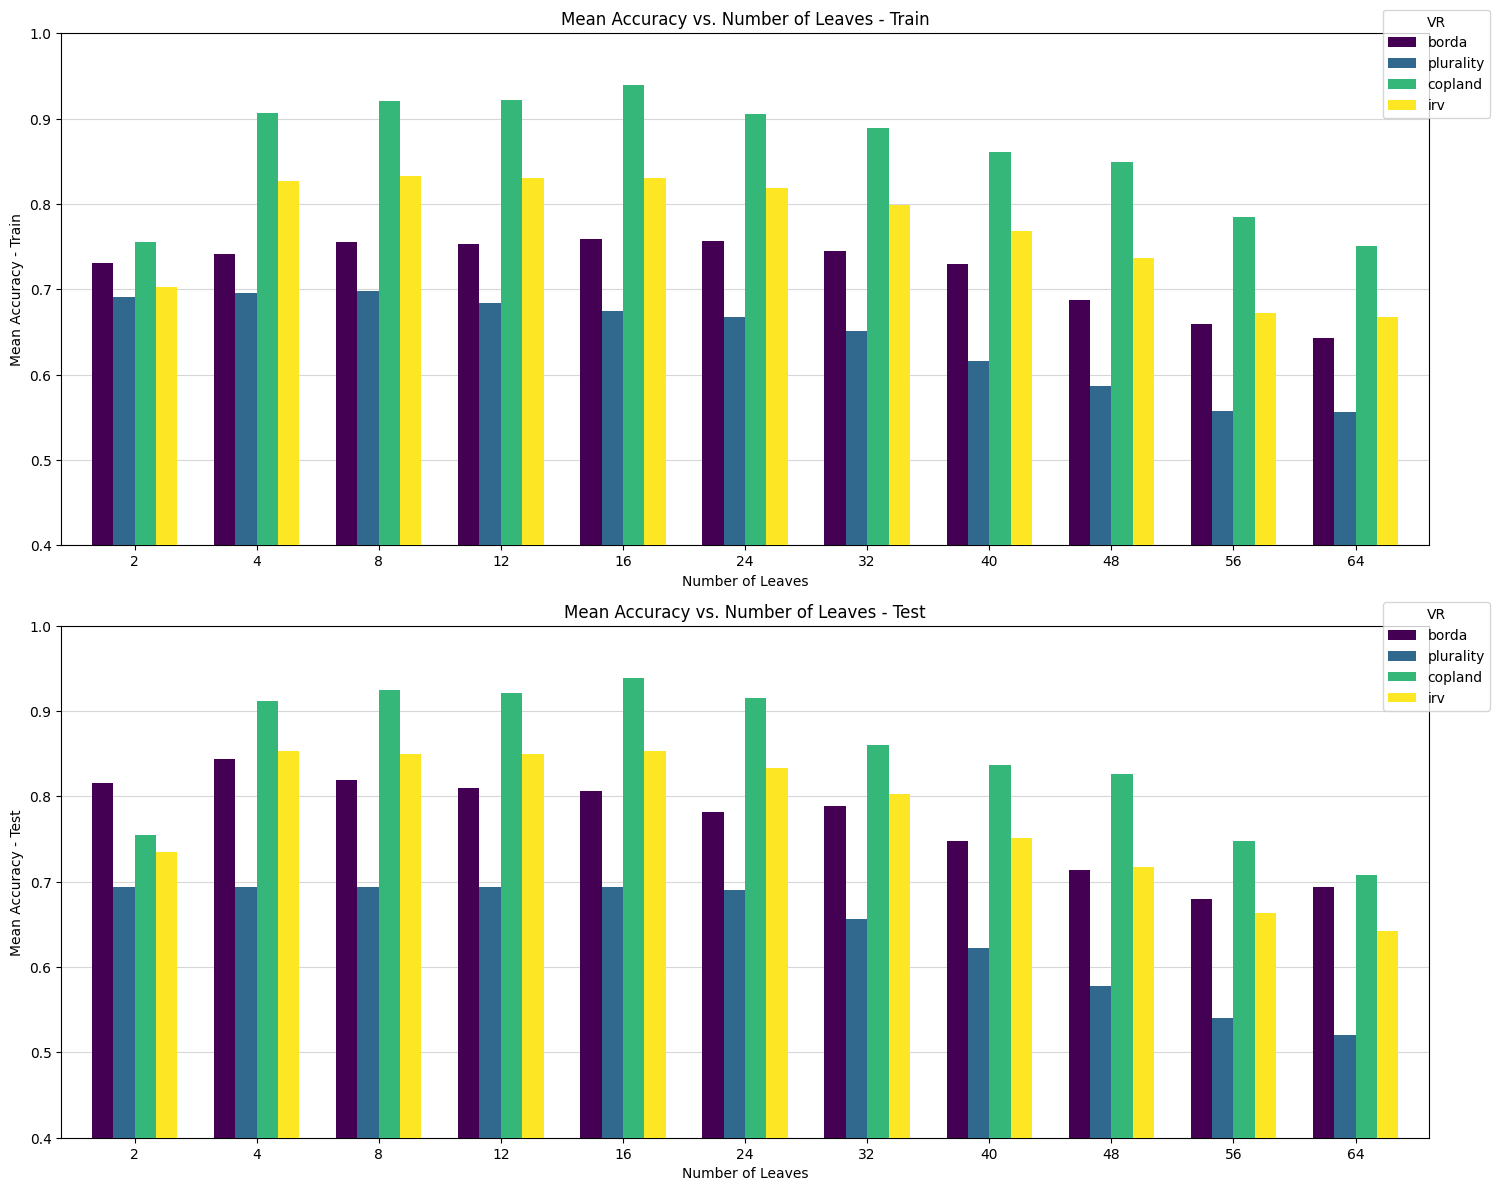

In [ ]:
def plot_accuracies_bar(accuracies, train=False, ax=None):
    order_bars = ["borda", "plurality", "copland", "irv"]

    data = []
    for vr in accuracies:
        for leaf in accuracies[vr]:
            mean_acc = np.mean(list(accuracies[vr][leaf].values()))
            data.append([vr, leaf, mean_acc])

    df = pd.DataFrame(data, columns=["vr", "leaf", "accuracy"])

    df_pivot = df.pivot(index="leaf", columns="vr", values="accuracy")
    df_pivot = df_pivot.reindex(columns=order_bars, fill_value=np.nan)

    cmap = cm.get_cmap("viridis", len(order_bars))
    colors = [cmap(i) for i in range(len(order_bars))]

    df_pivot.plot(kind="bar", ax=ax, width=0.7, zorder=3, color=colors)

    ax.set_xlabel("Number of Leaves")
    ax.set_ylabel("Mean Accuracy - Train" if train else "Mean Accuracy - Test")
    ax.set_title("Mean Accuracy vs. Number of Leaves - Train" if train else "Mean Accuracy vs. Number of Leaves - Test")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title="VR", loc="upper right", bbox_to_anchor=(1.05, 1.06))
    ax.grid(axis="y", linestyle="-", alpha=0.5, zorder=0)
    ax.set_ylim(0.4, 1)

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

plot_accuracies_bar(accuracies_train, train=True, ax=axes[0])
plot_accuracies_bar(accuracies_test, train=False, ax=axes[1])

plt.tight_layout()
plt.show()


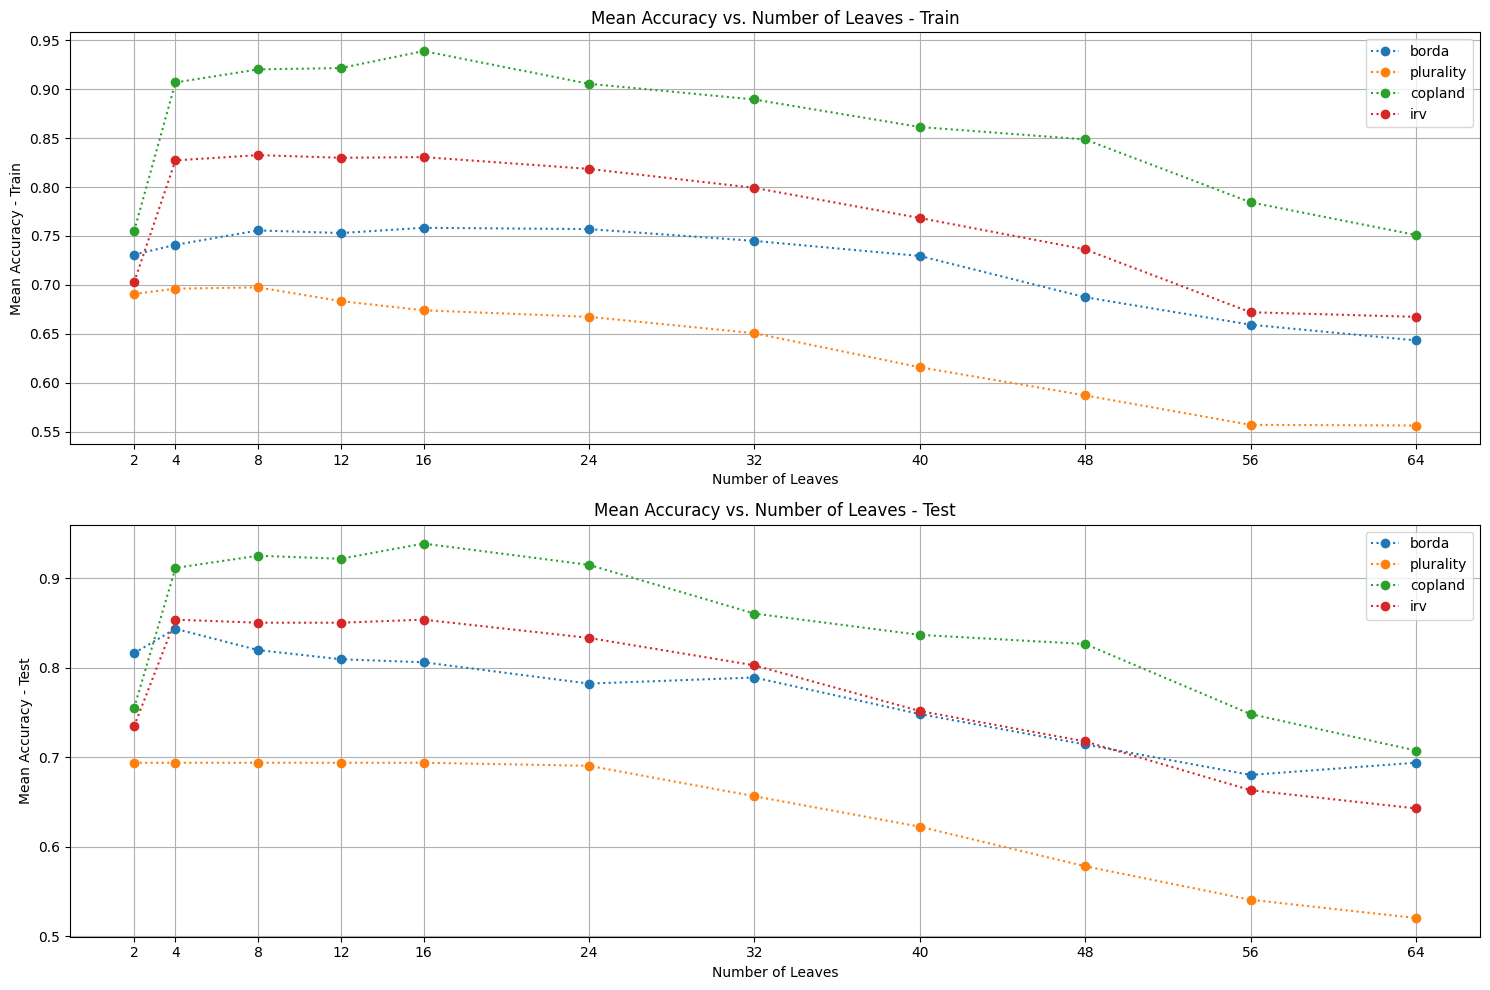

In [ ]:
def plot_accuracies_line(accuracies, train=False, ax=None):
    for vr in accuracies:
        x_values = sorted(accuracies[vr].keys())
        mean_accuracies = [np.mean(list(accuracies[vr][leaf].values())) for leaf in x_values]
        ax.plot(x_values, mean_accuracies, marker='o',  linestyle='dotted', markersize=6, label=vr)

    ax.set_xlabel("Number of Leaves")
    if train:
        ax.set_ylabel("Mean Accuracy - Train")
        ax.set_title("Mean Accuracy vs. Number of Leaves - Train")
    else:
        ax.set_ylabel("Mean Accuracy - Test")
        ax.set_title("Mean Accuracy vs. Number of Leaves - Test")

    ax.set_xticks(sorted(accuracies[next(iter(accuracies))].keys()))
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # 2 rows, 1 column

plot_accuracies_line(accuracies_train, train=True, ax=axes[0])
plot_accuracies_line(accuracies_test, train=False, ax=axes[1])

plt.tight_layout()

plt.show()

Discussion on the meaned accuracies results above:

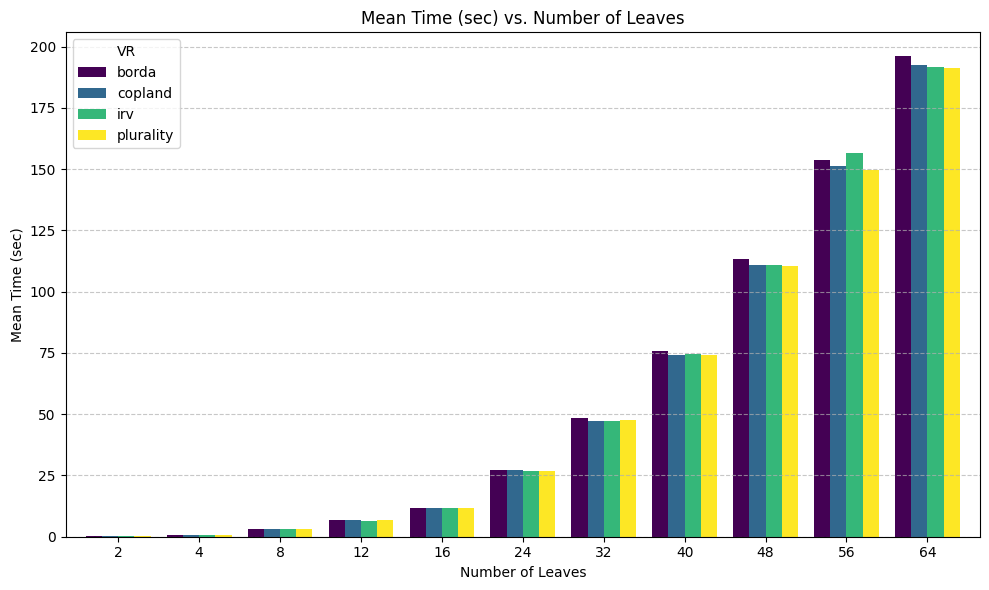

In [ ]:
def plot_time_learn_dict_bar(time_learn_dict):
    data = []
    for vr in time_learn_dict:
        for leaf in time_learn_dict[vr]:
            mean_acc = np.mean(list(time_learn_dict[vr][leaf].values()))
            data.append([vr, leaf, mean_acc])

    df = pd.DataFrame(data, columns=["vr", "leaf", "Time (sec)"])

    df_pivot = df.pivot(index="leaf", columns="vr", values="Time (sec)")

    ax = df_pivot.plot(kind="bar", figsize=(10, 6), colormap="viridis", width=0.8)

    ax.set_xlabel("Number of Leaves")
    ax.set_ylabel("Mean Time (sec)")
    ax.set_title("Mean Time (sec) vs. Number of Leaves")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title="VR")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plot_time_learn_dict_bar(time_learn_dict)

plt.tight_layout()
plt.show()

<ipython-input-22-a623214e99e9>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(time_learn_dict))


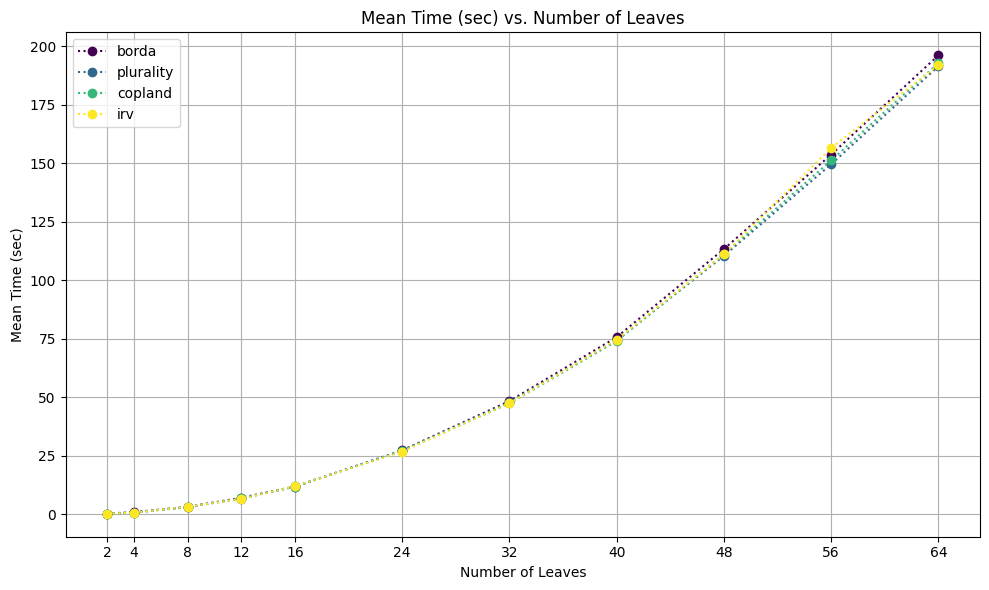

In [ ]:
def plot_time_learn_dict_line(time_learn_dict, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    cmap = cm.get_cmap('viridis', len(time_learn_dict))
    colors = {vr: cmap(i) for i, vr in enumerate(time_learn_dict)}

    for vr in time_learn_dict:
        x_values = sorted(time_learn_dict[vr].keys())
        mean_times = [np.mean(list(time_learn_dict[vr][leaf].values())) for leaf in x_values]

        ax.plot(x_values, mean_times, marker='o', linestyle='dotted',
                markersize=6, label=vr, color=colors[vr])

    ax.set_xlabel("Number of Leaves")
    ax.set_ylabel("Mean Time (sec)")
    ax.set_title("Mean Time (sec) vs. Number of Leaves")

    ax.set_xticks(sorted(time_learn_dict[next(iter(time_learn_dict))].keys()))
    ax.legend()
    ax.grid(True)

fig, ax = plt.subplots(figsize=(10, 6))

plot_time_learn_dict_line(time_learn_dict, ax=ax)

plt.tight_layout()
plt.show()

As can be observd above, the running time of finding a good assignment for the leaves is exponential on the number of leaves. Similar to the discussed on the original paper.

# Comparison between expected figure and empirical figure

<ipython-input-19-ad428f81cb70>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(order_bars))


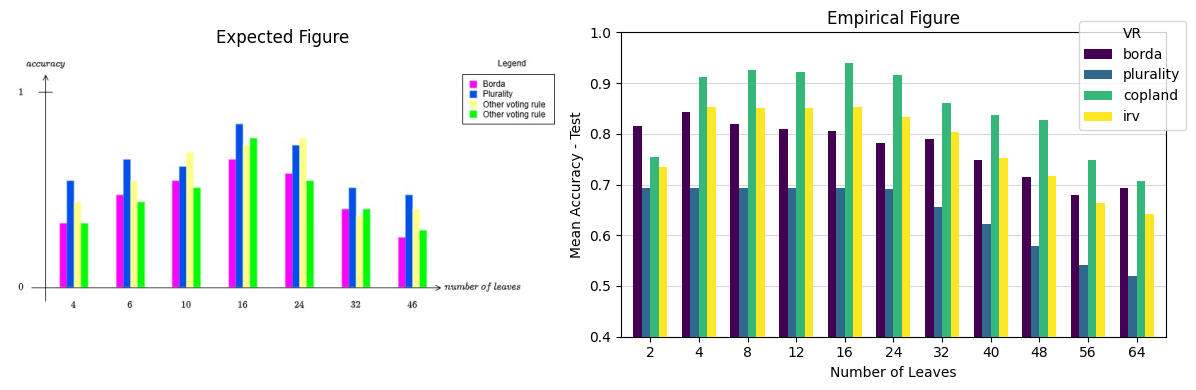

In [ ]:
img1 = mpimg.imread('good_expected_choices.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img1)
axes[0].set_title("Expected Figure")
axes[0].axis('off')

plot_accuracies_bar(accuracies_test, train= False, ax=axes[1])
axes[1].set_title("Empirical Figure")

plt.tight_layout()
plt.show()

Above, we see a side-by-side comparison of the expected figure (right) and the empirical results of the meaned accuracies (left).

Important Note: The scales on both graphs differ. This adjustment allows us to more clearly observe trends, particularly in the line graph.

Initially, we expected the distribution of meaned accuracies to resemble a normal distribution centered around the number of alternatives. This expectation stems from the idea that having too few or too many leaves could lead to underfitting or overfitting the data.

Based on the observed accuracy graph, we can conclude that mean accuracy tends to be higher when the number of leaves is closer to the number of alternatives. However, the difference is not as pronounced as initially anticipated.